## STAT 542 - Project 2 : Question 1 Models
##### Neeraj Wagh (nwagh2), Sunny Katiyar (sunnyk2), Pradnyesh Joshi (pvjoshi2)

### Reading data

In [1]:
import random
import matplotlib.pyplot as plt
import cv2
random.seed(10)

def read_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def resize_img(img, output_dim = (400, 300)):
    resized_img = cv2.resize(img, output_dim, interpolation = cv2.INTER_AREA)
    return resized_img

def show_img(img):
    plt.imshow(img)
    plt.show()

img = read_img('data/benign/ISIC_0000000.jpg')
show_img(img)
# img

<Figure size 640x480 with 1 Axes>

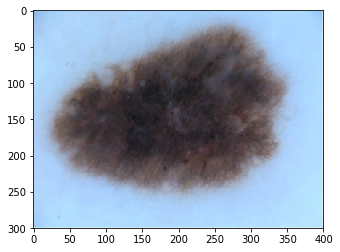

In [2]:
resized_img = resize_img(img)
show_img(resized_img)

In [3]:
from os import listdir
from os.path import isfile, join
from tqdm import tqdm_notebook
import numpy as np

def read_folder(folder_path):
    flist = [folder_path + f for f in listdir(folder_path) if isfile(join(folder_path, f))]
    img_arr = []
    for fpath in tqdm_notebook(flist):
        img = read_img(fpath)
        img = resize_img(img).flatten()
        img_arr.append(img)
    img_arr = np.array(img_arr)
    return img_arr

folder_path = 'data/benign/'
benign_img = read_folder(folder_path)
folder_path = 'data/malignant/'
malignant_img = read_folder(folder_path)
img_arr = np.append(benign_img, malignant_img, axis=0)

### Scaling data

In [5]:
from sklearn.preprocessing import scale
img_scaled = scale(img_arr, axis=0)

/Users/prady/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


### PCA

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
img_pca = pca.fit_transform(img_scaled)

In [95]:
# img_pca = img_pca[:,0:20]
from sklearn.decomposition import PCA
pca_full = PCA(n_components=36000)
img_pca_full = pca_full.fit_transform(img_scaled)

0.9679927864437895
300


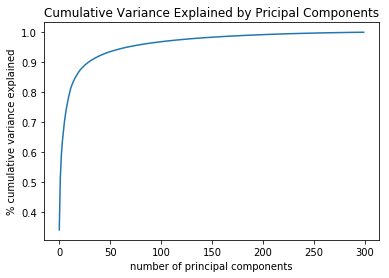

In [101]:
comp_variance = np.var(img_pca_full, axis=0)
comp_variance_perc = comp_variance/np.sum(comp_variance)
# plt.plot(comp_variance_perc)
 
print(sum(comp_variance_perc[0:100]))
 
print(len(comp_variance_perc))

plt.title('Cumulative Variance Explained by Pricipal Components')
plt.xlabel('number of principal components')
plt.ylabel('% cumulative variance explained')
plt.plot(comp_variance_perc.cumsum())

### Train Test split

In [8]:
y = np.append(np.zeros(shape = int(img_arr.shape[0]/2)), np.ones(shape = int(img_arr.shape[0]/2)))
x = img_pca

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0, stratify=y)

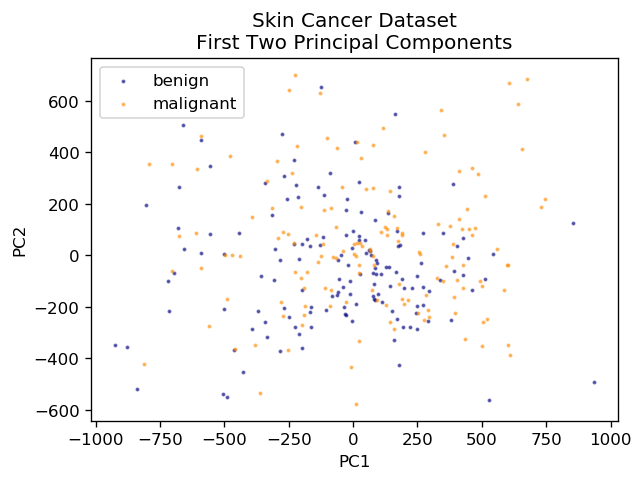

In [94]:
plt.figure(dpi=120)
plt.scatter(img_pca[y==0,0], img_pca[y==0,1], alpha=0.5, label='benign', s=2, color='navy')
plt.scatter(img_pca[y==1,0], img_pca[y==1,1], alpha=0.5, label='malignant', s=2, color='darkorange')
plt.legend()
plt.title('Skin Cancer Dataset\nFirst Two Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.gca().set_aspect('equal')
plt.show()

# Model 1: Penalized Logistic Regression

In [9]:
def accuracy(y, y_hat):
    return (y_hat == y).mean()

######  Hyperparameter tuning using GridSearchCV

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import time

start_time = time.time()
tuned_parameters = [{'penalty': ['l2', 'l1'], 'C': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]},
                   {'penalty':['elasicnet'], 'solver':['saga'], 'C':[1e-6, 1e-5, 1e-4, 1e-3, 1e-2]}]

logistic_model = GridSearchCV(LogisticRegression(random_state=0, multi_class='ovr', tol=1e-5, max_iter = 8000),
                              tuned_parameters, cv=5, scoring='f1', n_jobs=-1)
logistic_model.fit(x_train, y_train)
print("finished tuning penalized LR in ", time.time()-start_time)

/Users/prady/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/prady/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/prady/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/prady/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/prady/anaconda3/lib/python3.7/site-packages/sklearn/m

finished tuning penalized LR in  7.449799060821533


In [11]:
logistic_model.best_params_

{'C': 0.001, 'penalty': 'l1'}

######  Predicting on train and test

In [12]:
yhat_train = logistic_model.predict(x_train)
yhat_test = logistic_model.predict(x_test)

###### Checking train accuracy

In [13]:
accuracy(y_train, yhat_train)

0.6857142857142857

###### Checking test accuracy

In [14]:
accuracy(y_test, yhat_test)

0.7333333333333333

###### Checking other model performance scores

In [15]:
from sklearn.metrics import classification_report, roc_auc_score
from pprint import pprint

pprint(classification_report(y_train, yhat_train))
pprint(classification_report(y_test, yhat_test))

print(roc_auc_score(y_train, yhat_train))
print(roc_auc_score(y_test, yhat_test))

('             precision    recall  f1-score   support\n'
 '\n'
 '        0.0       0.67      0.74      0.70       105\n'
 '        1.0       0.71      0.63      0.67       105\n'
 '\n'
 'avg / total       0.69      0.69      0.68       210\n')
('             precision    recall  f1-score   support\n'
 '\n'
 '        0.0       0.72      0.76      0.74        45\n'
 '        1.0       0.74      0.71      0.73        45\n'
 '\n'
 'avg / total       0.73      0.73      0.73        90\n')
0.6857142857142857
0.7333333333333333


###### Plotting the coefficients of the model

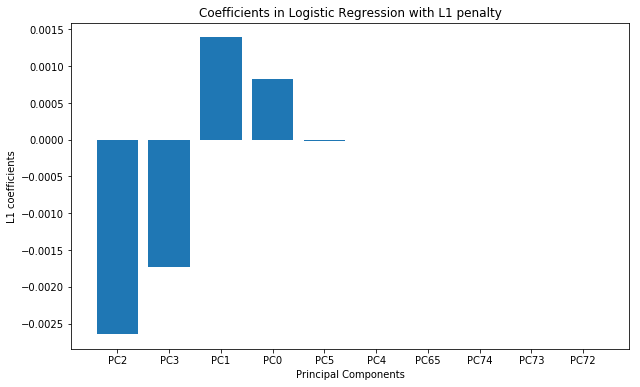

In [92]:
import pandas as pd

l1_coef = logistic_model.best_estimator_.coef_
l1_coef = l1_coef.reshape(l1_coef.shape[1])
pc = ['PC' + str(i) for i in range(len(l1_coef))]
fimp_df = pd.DataFrame({'l1_coefficient': l1_coef, 'pc':pc})
fimp_df['abs_coef'] = fimp_df['l1_coefficient'].abs()
fimp_df.sort_values(by = 'abs_coef', ascending=False, inplace=True)
fimp_df.reset_index(inplace=True)

n_pc=10
plt.figure(figsize=(10,6))
plt.bar(fimp_df.pc[0:n_pc], fimp_df.l1_coefficient[0:n_pc])
plt.title('Coefficients in Logistic Regression with L1 penalty')
plt.xlabel('Principal Components')
plt.ylabel('L1 coefficients')
plt.show()

# Model 2: XGBoost

######  Hyperparameter tuning using GridSearchCV

In [16]:
from xgboost import XGBClassifier
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1],
        'reg_alpha': [2, 4],
        'reg_lambda': [4, 6],
        'gamma': [2, 4],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.2, 0.4],
        'max_depth': [3],
        'n_estimators': [1500, 2000]
        }
xgb = XGBClassifier(learning_rate=0.01, objective='binary:logistic',
                    silent=True, nthread=-1, random_state=0)

In [17]:
xgb_model = GridSearchCV(estimator=xgb, param_grid=params, scoring='f1', n_jobs=-1, cv=5, verbose=1)

In [18]:
import warnings, time
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)
start_time = time.time()
xgb_model.fit(x_train, y_train)
print("finished tuning XGBoost in ", time.time()-start_time)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  3.0min finished


finished tuning XGBoost in  180.66646003723145


###### Predicting on train and test

In [19]:
yhat_train = xgb_model.predict(x_train)
yhat_test = xgb_model.predict(x_test)

###### Checking train accuracy

In [20]:
accuracy(y_train, yhat_train)

0.8523809523809524

###### Checking test accuracy

In [5]:
accuracy(y_test, yhat_test)

0.7777777777777778

###### Checking other model performance scores

In [23]:
from sklearn.metrics import classification_report, roc_auc_score
from pprint import pprint

pprint(classification_report(y_train, yhat_train))
pprint(classification_report(y_test, yhat_test))

print(roc_auc_score(y_train, yhat_train))
print(roc_auc_score(y_test, yhat_test))

('             precision    recall  f1-score   support\n'
 '\n'
 '        0.0       0.84      0.87      0.85       105\n'
 '        1.0       0.86      0.84      0.85       105\n'
 '\n'
 'avg / total       0.85      0.85      0.85       210\n')
('             precision    recall  f1-score   support\n'
 '\n'
 '        0.0       0.82      0.71      0.76        45\n'
 '        1.0       0.75      0.84      0.79        45\n'
 '\n'
 'avg / total       0.78      0.78      0.78        90\n')
0.8523809523809525
0.7777777777777778


###### Checking Feature Importance

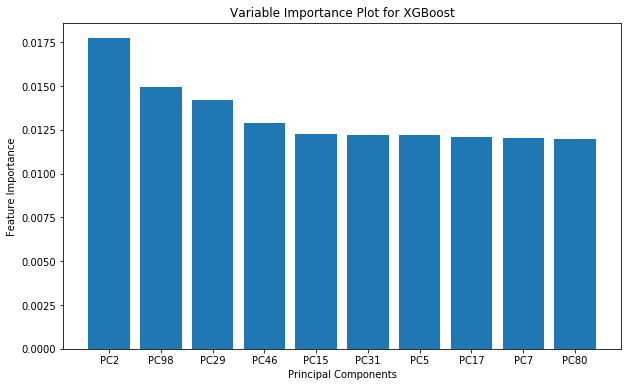

In [71]:
import pandas as pd

feature_imp = xgb_model.best_estimator_.feature_importances_
pc = ['PC' + str(i) for i in range(len(feature_imp))]
fimp_df = pd.DataFrame({'feature_importance': feature_imp, 'pc':pc})
fimp_df.sort_values(by = 'feature_importance', ascending=False, inplace=True)
fimp_df.reset_index(inplace=True)

n_pc=10
plt.figure(figsize=(10,6))
plt.bar(fimp_df.pc[0:n_pc], fimp_df.feature_importance[0:n_pc])
plt.title('Variable Importance Plot for XGBoost')
plt.xlabel('Principal Components')
plt.ylabel('Feature Importance')
plt.show()

# Model 3: SVM

In [26]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

###### Hyperparameter tuning using GridSearchCV

In [27]:
random.seed(10)
start_time = time.time()
 
# defining parameter range
param_grid = {'C': [1e-6, 1e-4, 1e-2, 0.1],
              'kernel': ['linear']} 

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1, cv=5)
  
# fitting the model for grid search
grid.fit(x_train, y_train)
grid.best_params_
print("finished tuning SVM in ", time.time()-start_time)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
finished tuning SVM in  0.6328380107879639


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.6s finished


In [28]:
best_SVM_model = grid.best_estimator_

###### Checking Train Accuracy

In [29]:
yhat_train = best_SVM_model.predict(x_train)
accuracy(y_train, yhat_train)

0.7095238095238096

###### Checking Test Accuracy

In [30]:
yhat_test = best_SVM_model.predict(x_test)
accuracy(y_test, yhat_test)

0.7333333333333333

In [31]:
grid.best_params_

{'C': 1e-06, 'kernel': 'linear'}

###### Checking other model performance scores

In [32]:
from sklearn.metrics import classification_report, roc_auc_score
from pprint import pprint
pprint(classification_report(y_train, yhat_train))

('             precision    recall  f1-score   support\n'
 '\n'
 '        0.0       0.68      0.79      0.73       105\n'
 '        1.0       0.75      0.63      0.68       105\n'
 '\n'
 'avg / total       0.72      0.71      0.71       210\n')


In [33]:
pprint(classification_report(y_test, yhat_test))

('             precision    recall  f1-score   support\n'
 '\n'
 '        0.0       0.70      0.82      0.76        45\n'
 '        1.0       0.78      0.64      0.71        45\n'
 '\n'
 'avg / total       0.74      0.73      0.73        90\n')


In [34]:
roc_auc_score(y_train, yhat_train)

0.7095238095238094

In [35]:
roc_auc_score(y_test, yhat_test)

0.7333333333333333

###### Plotting the coefficients  of SVM model

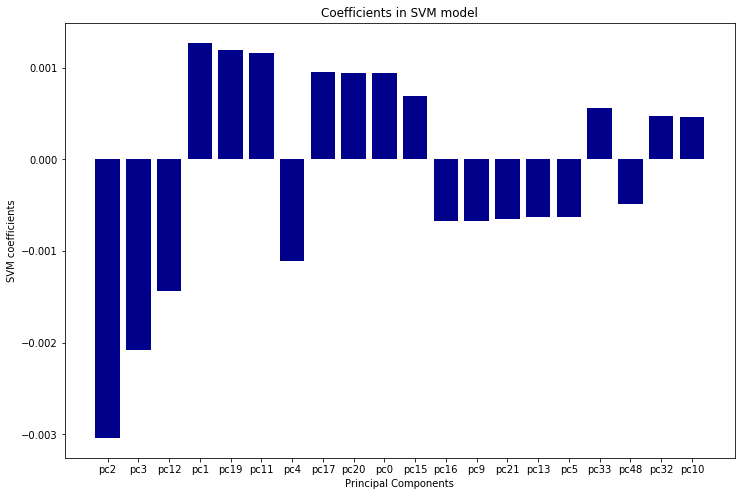

In [102]:
svm_coef = best_SVM_model.coef_
pc_names = ["pc" + str(i) for i in range(0,100)]
# pc_names = list(feature_data.columns[0:4])
 
svm_coef = svm_coef.reshape(svm_coef.shape[1])
 
fimp_df = pd.DataFrame({'svm_coef': svm_coef, 'pc_names':pc_names})
fimp_df['abs_coef'] = fimp_df['svm_coef'].abs()
fimp_df.sort_values(by = 'abs_coef', ascending=False, inplace=True)
fimp_df.reset_index(inplace=True)
 
n_pc=20
fig = plt.figure(figsize=(12,8))
#plt.figure
plt.bar(fimp_df.pc_names[0:n_pc], fimp_df.svm_coef[0:n_pc], color=['darkblue'])
plt.title('Coefficients in SVM model')
plt.xlabel('Principal Components')
plt.ylabel('SVM coefficients')
plt.show()
#fig.savefig('svm_coef.png')